In [223]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import torch
import torch.nn.functional as F
# from scipy.spatial.distance import pdist
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
from utils import *
import os
import importlib
import sys
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
sys.path.append("../hw07")

# from hw07 import my_utils 
from my_utils import my_test, evaluate_regression_model, plot_mollies



In [202]:
# print(os.path.abspath(__file__))

In [203]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

## MD step function

In [205]:
def energy_lj(r: torch.tensor, epsilon: float = 1.0, sigma: float = 1.0):
    """Compute the Lennard-Jones energy of a system with positions r

    Parameters
    ----------
    r: atomic configuration

    sigma: LJ potential parameter sigma, default 1.0

    epsilon: LJ potential parameter epsilon, default 1.0

    Return
    ------
    ene: total LJ energy of atomic configuration

    """
    def lj(dist, epsilon: float = 1.0, sigma: float = 1.0):
        return 4 * epsilon * ((sigma / dist)**12 - (sigma / dist)**6)

    distances = F.pdist(r)

    pair_energies = torch.vmap(lj)(distances)

    return torch.sum(pair_energies)

In [206]:
def get_forces(energy_fn, r: torch.Tensor):

    """Computes the forces acting on a configuration r for a given energy function using backpropagation.

    Parameters
    ----------
    r: atomic configuration

    energy_fn: energy function


    Return
    ------
    f: atomic forces
    """

    assert r.requires_grad == False

    r.requires_grad = True

    # evaluate energy
    energy = energy_fn(r)

    # compute gradients w.r.t. r
    energy.backward()

    # get gradients w.r.t. r
    forces = -r.grad

    r.requires_grad = False
    return forces

In [207]:
def verlet_step(
    r: torch.tensor,
    v: torch.tensor,
    f: torch.tensor,
    energy_fn: callable,
    dt: float,
    m: float = 1.0,
):
    """velocity Verlet step: MD in NVE ensemble.

    Parameters
    ----------
    r: positions

    v: velocities

    f: forces

    dt: time step

    m: mass

    energy_fn: energy function

    Return
    ------
    r: updated position

    v: updated velocities

    f: updated forces


    """
    # Remove center of mass motion
    com = torch.mean(v, axis=0)
    v -= com

    # update velocity 1/2 step
    v += 0.5 * f / m * dt

    # update positions
    r = r + v * dt

    f = get_forces(energy_fn, r)

    # update velocity 1/2 step
    v += 0.5 * f / m * dt

    return r, v, f


## Example MD run

In [208]:
d = 1.1

# 3d cluster
clus3d = torch.tensor(
    [
        [0.0, 0.0, 0.0],
        [d / np.sqrt(2.), d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), d / np.sqrt(2), 0.0],
        [d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [0, 0, d],
        [0, 0, -d],
    ],dtype=torch.float32
)

In [209]:
def assign_MBv(n_particles, beta, m: float = 1.0):
    """Assign Maxwell-Boltzmann distributed velocities.

    Parameters
    ----------
    v: velocity array

    beta: 1/ (kB * T)

    m: atomic mass


    Return
    ------
    v:     velocity array

    """

    v = torch.normal(mean=0, std=np.sqrt(1.0 / (beta * m)), size=(n_particles, 3))

    return v

In [210]:
r = torch.clone(clus3d)

n_particles = len(r)

# compute LJ energy
energy = energy_lj(clus3d)

# set inverse temp \beta = 1 / (kB * T)
beta = 100.0
m = 1.0

dt = 1e-3
n_dimensions = r.shape[-1]

In [211]:
# initialize number of MD steps
n_steps = 100000

n_log = 50

# energies
potential_energies = torch.empty((n_steps // n_log, 1))
kinetic_energies = torch.empty((n_steps // n_log, 1))
positions = torch.empty((n_steps // n_log, n_particles, n_dimensions))

In [212]:
# assign intial structure
r = torch.clone(clus3d)

# assign intial MB velocities
v = assign_MBv(n_particles, beta, m)

# compute initial forces
f = get_forces(energy_lj, r)


In [213]:
# run velocity Verlet
num_particles = len(v)

for i in range(n_steps):
    if i % n_log == 0:
        positions[i // n_log] = r
        potential_energies[i // n_log] = energy_lj(r)
        kinetic_energies[i // n_log] = .5 * (m) * (v ** 2).sum()

    r, v, f = verlet_step(r, v, f, energy_lj, dt, m)

In [214]:
num_particles = len(v)

Text(0.5, 1.0, 'Histogram of Potential Energies from first simulation')

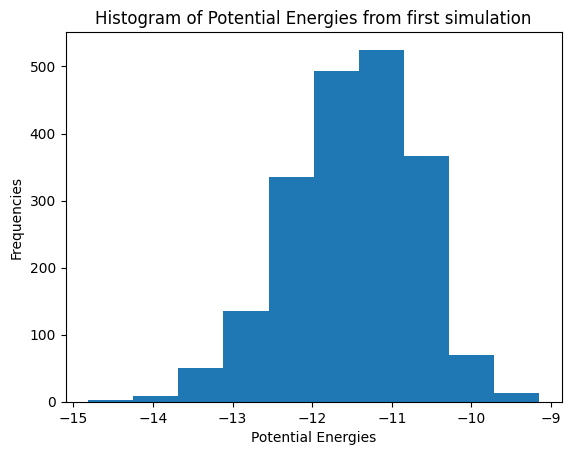

In [215]:
plt.hist(potential_energies)
plt.xlabel('Potential Energies')
plt.ylabel('Frequencies')
plt.title('Histogram of Potential Energies from first simulation')

Text(0.5, 1.0, 'Potential Energy over time for first simulation')

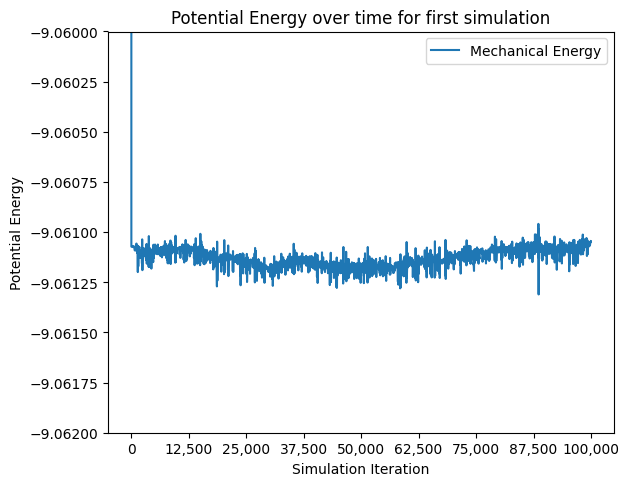

In [248]:
# plt.plot(potential_energies, label="Potential Energy")
# plt.plot(kinetic_energies, label="Kinetic Energy")
plt.plot(potential_energies + kinetic_energies, label="Mechanical Energy")

def scale_index(x, pos):
    scaled_value = int(x * n_log)  # Scale the value
    return f'{scaled_value:,}'  # Format with commas
# Apply the formatter to the x-axis
formatter = FuncFormatter(scale_index)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('Simulation Iteration')
plt.ylabel('Potential Energy')
# plt.xlim(0,10)
plt.ylim(-9.062, -9.06)
# plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.title('Potential Energy over time for first simulation')

In [217]:
# 1.2

# distances = sorted(pdist(positions[0].numpy(), metric='euclidean')) # There's probably a way to do this with cdist and avoiding using numpy
# distances

sorted_pairwise_distances = [torch.sort(F.pdist(position_set))[0] for position_set in positions]
len(sorted_pairwise_distances[0])

21

In [218]:
class PairwiseDistanceDataset(Dataset):
    def __init__(self, positions, energies):
        self.features = [torch.sort(F.pdist(position_set))[0] for position_set in positions]
        self.labels = energies.view(-1, 1)  # Ensure labels have shape (n_samples, 1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [219]:

dataset = PairwiseDistanceDataset(positions, potential_energies)

train_size = int(0.8 * len(dataset))
test_size = val_size = (len(dataset) - train_size) // 2
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [220]:
num_pairs = int(num_particles * (num_particles - 1) / 2)
architecture = [num_pairs] + [50] * 8 + [1]
# print(architecture)
model = MLP(architecture).to(DEVICE)
coords = torch.optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)
losses = []
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [239]:
EPOCHS = 4000

epochs_per_loss_record = 1

for epoch in range(EPOCHS):
    losses.append(train(model, train_loader, optimizer, criterion, DEVICE))
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {losses[-1]}")
torch.save(model.state_dict(), "model_weights_hw08.pth")

Epoch: 0 | Loss: 0.006012272061780095
Epoch: 10 | Loss: 0.006877688225358725
Epoch: 20 | Loss: 0.007541536539793015
Epoch: 30 | Loss: 0.006726569086313247
Epoch: 40 | Loss: 0.006597193125635385
Epoch: 50 | Loss: 0.006698550824075937
Epoch: 60 | Loss: 0.006015673447400331
Epoch: 70 | Loss: 0.005850688759237528
Epoch: 80 | Loss: 0.006302348524332047
Epoch: 90 | Loss: 0.00613805647008121
Epoch: 100 | Loss: 0.006074464563280344
Epoch: 110 | Loss: 0.006783807836472988
Epoch: 120 | Loss: 0.005779771823436022
Epoch: 130 | Loss: 0.0063401833362877365
Epoch: 140 | Loss: 0.00613022880628705
Epoch: 150 | Loss: 0.00657345250248909
Epoch: 160 | Loss: 0.005944018550217152
Epoch: 170 | Loss: 0.007385620586574077
Epoch: 180 | Loss: 0.006545976232737303
Epoch: 190 | Loss: 0.006801424100995063
Epoch: 200 | Loss: 0.0064354949817061425
Epoch: 210 | Loss: 0.007764359526336193
Epoch: 220 | Loss: 0.0072694458439946175
Epoch: 230 | Loss: 0.006013115365058184
Epoch: 240 | Loss: 0.00660366197116673
Epoch: 250 |

Text(0, 0.5, 'Loss')

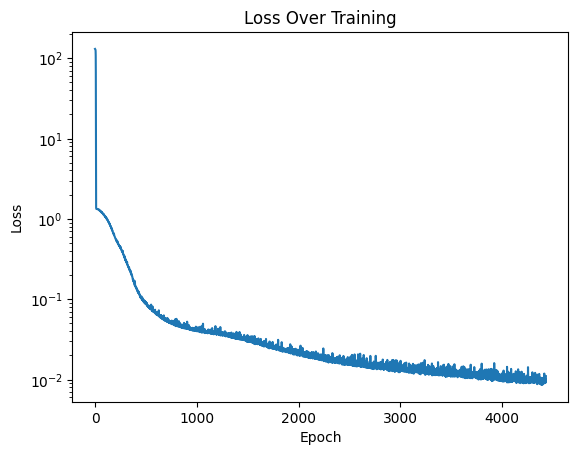

In [234]:
plt.plot(losses)
plt.title("Loss Over Training")
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")

TEST
hit plot


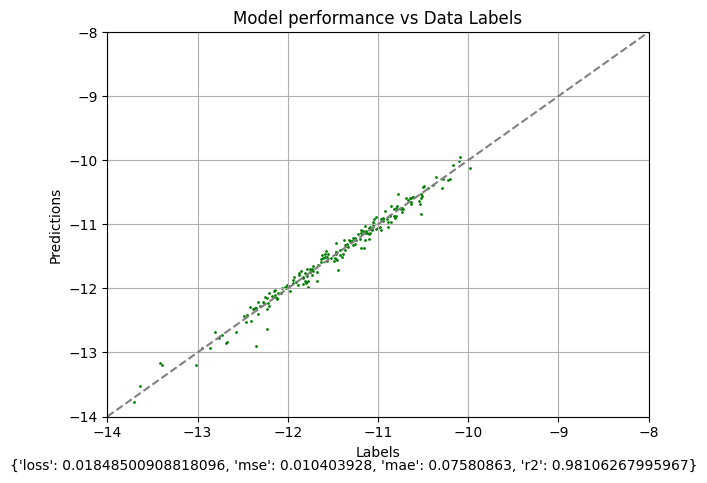

{'loss': 0.01848500908818096,
 'mse': 0.010403928,
 'mae': 0.07580863,
 'r2': 0.98106267995967}

In [238]:
evaluate_regression_model(model, test_loader, criterion, device=DEVICE, plot=True, xlabel="Labels", ylabel="Predictions", title="Model performance vs Data Labels", xlimits=[-14, -8], ylimits=[-14, -8])

In [ ]:
# 1.4
# print(num_pairs)

def energy_model(r):
  sorted_distances, indices =  torch.sort(torch.nn.functional.pdist(r))
  return model(sorted_distances)

r2 = torch.clone(clus3d).detach()
# n_particles = len(r2)
# compute LJ energy
energy = energy_model(clus3d)
# set inverse temp \beta = 1 / (kB * T)
beta = 100.0
m = 1.0
dt = 1e-3
# n_dimensions = r.shape[-1]
# assign intial structure
# assign intial MB velocities
v = assign_MBv(n_particles, beta, m)
# compute initial forces
f = get_forces(energy_lj, r2)

n_steps2 = n_steps
n_log2 = n_log

potential_energies2 = torch.empty((n_steps2 // n_log2, 1))
kinetic_energies2 = torch.empty((n_steps2 // n_log2, 1))
positions2 = torch.empty((n_steps2 // n_log2, n_particles, n_dimensions))

# r = r.clone().detach().requires_grad_(True)
# do another simulation just like the first
for i in range(n_steps):
    if i % n_log == 0:
        positions2[i // n_log] = r2
        potential_energies2[i // n_log] = energy_model(r2)
        kinetic_energies2[i // n_log] = .5 * (m) * (v ** 2).sum()

    r2, v, f = verlet_step(r2, v, f, energy_model, dt, m)
  
  

In [ ]:
# print(F.pdist(clus3d, p=2))
# print(torch.sort(F.pdist(clus3d, p=2)))
# print(energy_model(clus3d))
# print(energy_lj(clus3d))

plt.hist(potential_energies2)
plt.xlabel('Potential Energies for Model Simulation')
plt.ylabel('Frequencies')
plt.title('Histogram of Potential Energies from first simulation')


tensor([1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.5556, 1.5556, 2.2000,
        1.5556, 1.5556, 2.2000, 1.5556, 1.5556, 1.5556, 1.5556, 1.5556, 1.5556,
        1.5556, 1.5556, 2.2000])
torch.return_types.sort(
values=tensor([1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.5556, 1.5556, 1.5556,
        1.5556, 1.5556, 1.5556, 1.5556, 1.5556, 1.5556, 1.5556, 1.5556, 1.5556,
        2.2000, 2.2000, 2.2000]),
indices=tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 12, 13, 14, 15, 16, 17, 18, 19,
        11,  8, 20]))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 21x50)

In [ ]:
# plt.plot(potential_energies, label="Potential Energy")
# plt.plot(kinetic_energies, label="Kinetic Energy")
plt.plot(potential_energies + kinetic_energies, label="Original Simulation")
# plt.plot(potential_energies, label="Potential Energy")
# plt.plot(kinetic_energies, label="Kinetic Energy")
plt.plot(potential_energies2 + kinetic_energies2, label="Model Simulation")

def scale_index(x, pos):
    scaled_value = int(x * n_log)  # Scale the value
    return f'{scaled_value:,}'  # Format with commas
# Apply the formatter to the x-axis
formatter = FuncFormatter(scale_index)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('Simulation Iteration')
plt.ylabel('Potential Energy')
# plt.xlim(0,10)
plt.ylim(-9.062, -9.06)
# plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.title('Potential Energy over time for first simulation')

def scale_index(x, pos):
    scaled_value = int(x * n_log)  # Scale the value
    return f'{scaled_value:,}'  # Format with commas
# Apply the formatter to the x-axis
formatter = FuncFormatter(scale_index)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('Simulation Iteration')
plt.ylabel('Potential Energy')
# plt.xlim(0,10)
plt.ylim(-9.062, -9.06)
# plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.title('Potential Energy over time for first simulation')